In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp, sweep_poly
from librosa import cqt,stft, note_to_hz
from librosa.feature import melspectrogram
import sys
sys.path.insert(0,'../')
from scipy.io import wavfile

import Spectrogram
import torch
import torch.nn as nn

In [2]:
cmap = 'jet'
fmin = 55 # for CQT use

fs = 44100
t = 1
f0 = 55
f1 = 22050

# parameters for CQT
bins_per_octave = 24
n_bins = int(bins_per_octave*7.5)

epsilon = 1e-5 # for taking log

# Getting a chromatic scale audio

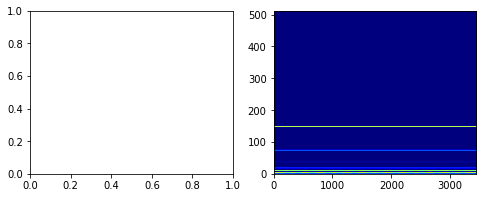

In [3]:
fs = 44100
s = np.linspace(0,10,fs*10)
x = np.sin(2*np.pi*100*s, dtype=np.float32) \
    + np.sin(2*np.pi*200*s, dtype=np.float32) + np.sin(2*np.pi*400*s, dtype=np.float32) \
    + np.sin(2*np.pi*800*s, dtype=np.float32) + np.sin(2*np.pi*1600*s, dtype=np.float32) \
    + np.sin(2*np.pi*3200*s, dtype=np.float32) + np.sin(2*np.pi*6400*s, dtype=np.float32) 

fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[1].imshow(abs(stft(x, n_fft=1024, hop_length=128)), origin='lower', aspect='auto', cmap=cmap)

# Comparing CQT results

## nnAudio

Low pass filter created, time used = 0.0023 seconds
No early downsampling is required, downsample_factor =  1
Early downsampling filter created, time used = 0.0001 seconds
CQT kernels created, time used = 0.0058 seconds
STFT kernels created, time used = 0.0962 seconds


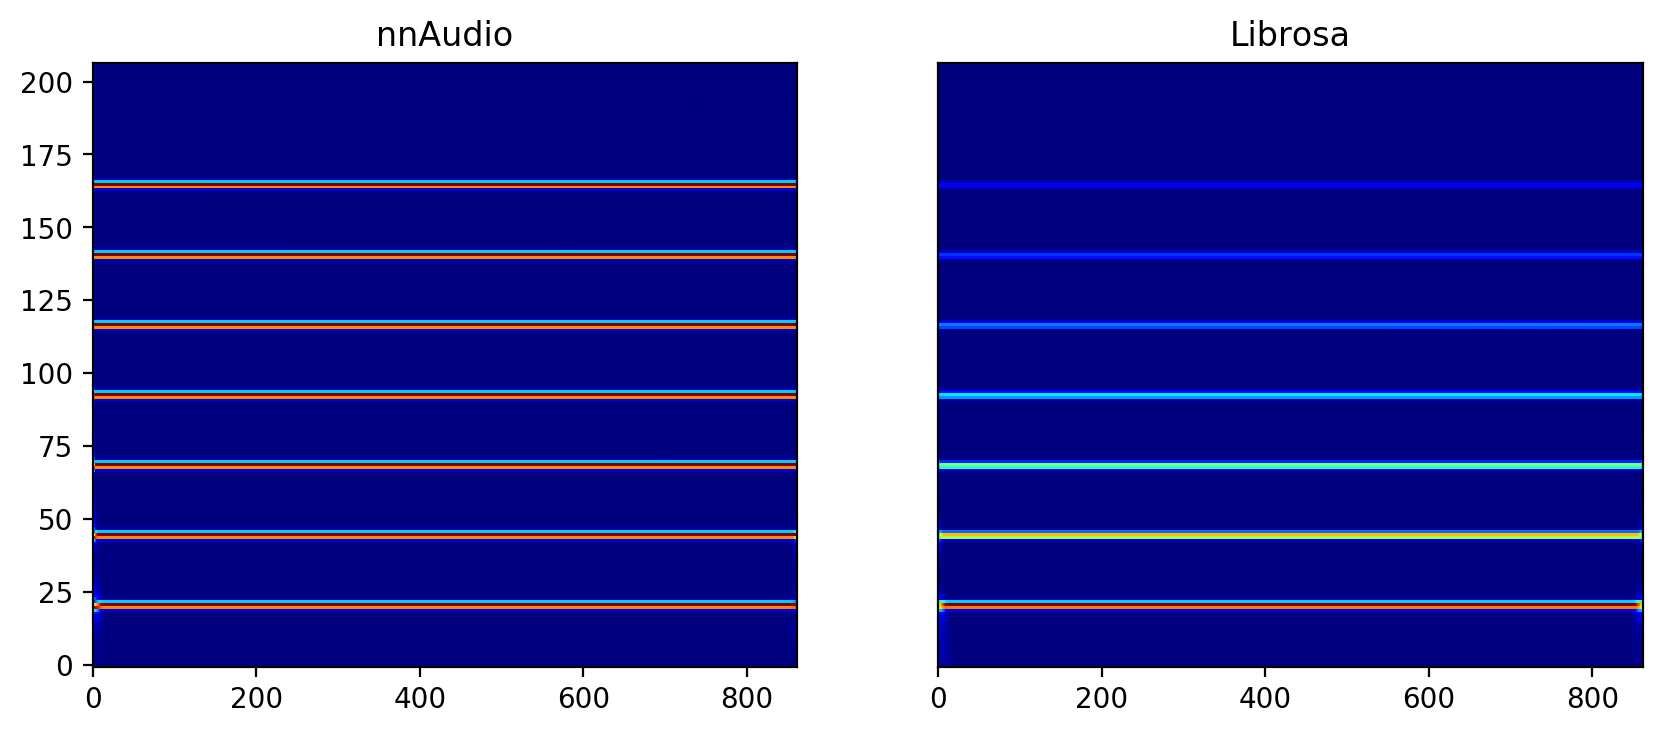

In [4]:
r=2
bins_per_octave = 12*r
n_bins = 104*r-1
CQT2010_layer = Spectrogram.CQT2010(fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)

cqt_x = CQT2010_layer(torch.tensor(x[None, None, :]))
output_lib = cqt(x, sr=fs, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, pad_mode='constant')

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))

im1 = ax[0].imshow(cqt_x[0], aspect='auto', origin='lower', cmap=cmap)
im2 = ax[1].imshow(abs(output_lib), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])

ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

# Melspectrogram

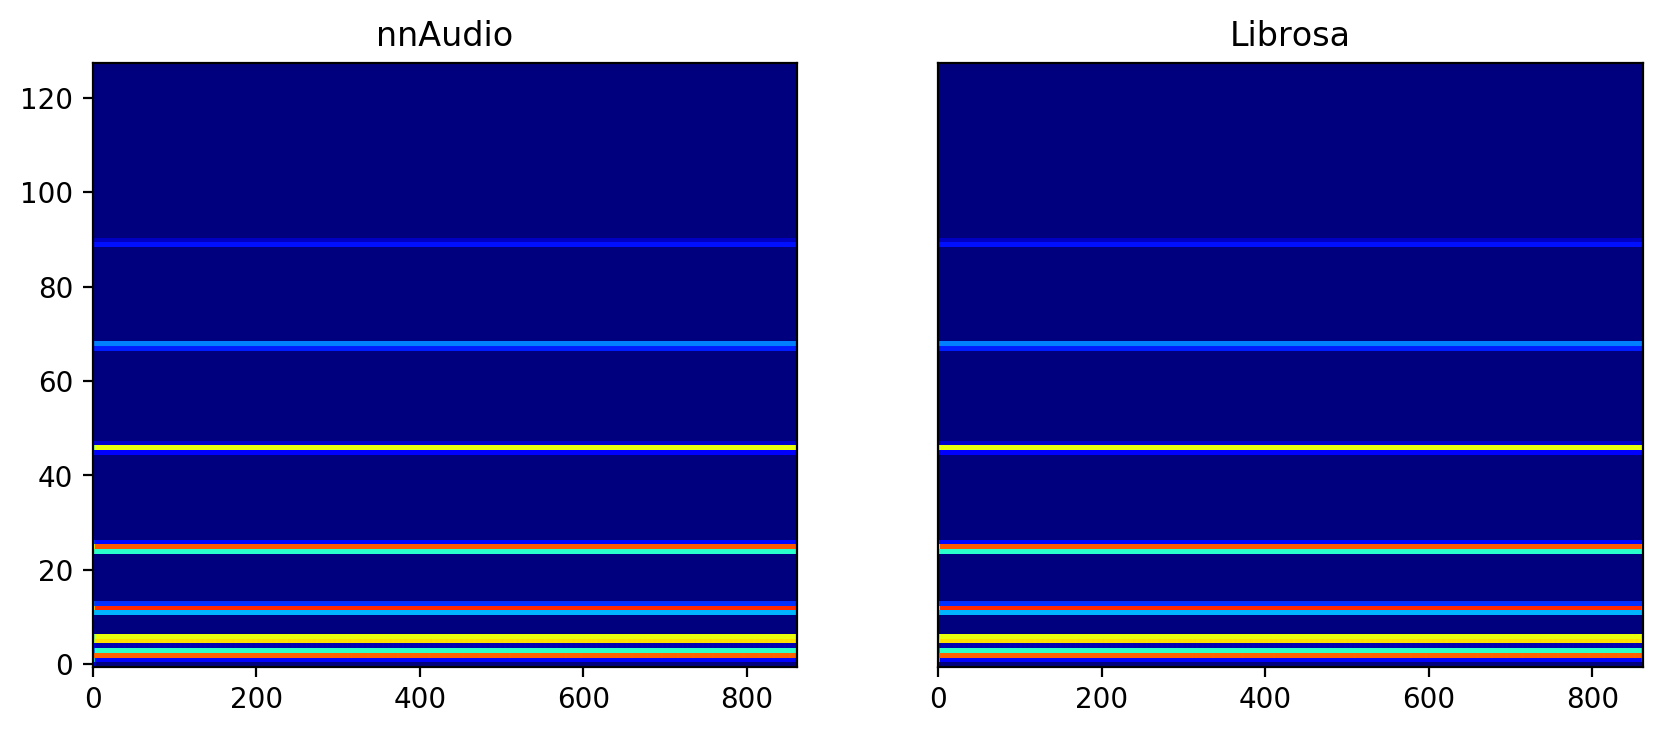

In [9]:
mel_layer = Spectrogram.MelSpectrogram(fs)
fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
mel_x = mel_layer(torch.tensor(x[None, None, :]))
output_lib = melspectrogram(x, fs)
ax[0].imshow(mel_x_linear[0], aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(output_lib, aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

In [10]:
print("Linear sweep all close ", np.allclose(mel_x[0].numpy(), output_lib, rtol=1e-3, atol=1e-4))

Linear sweep all close  True


# STFT linear freq

In [11]:
stft_layer_no = Spectrogram.STFT()
stft_x = stft_layer_no(torch.tensor(x[None, None, :]))

output_lib = abs(stft(x))

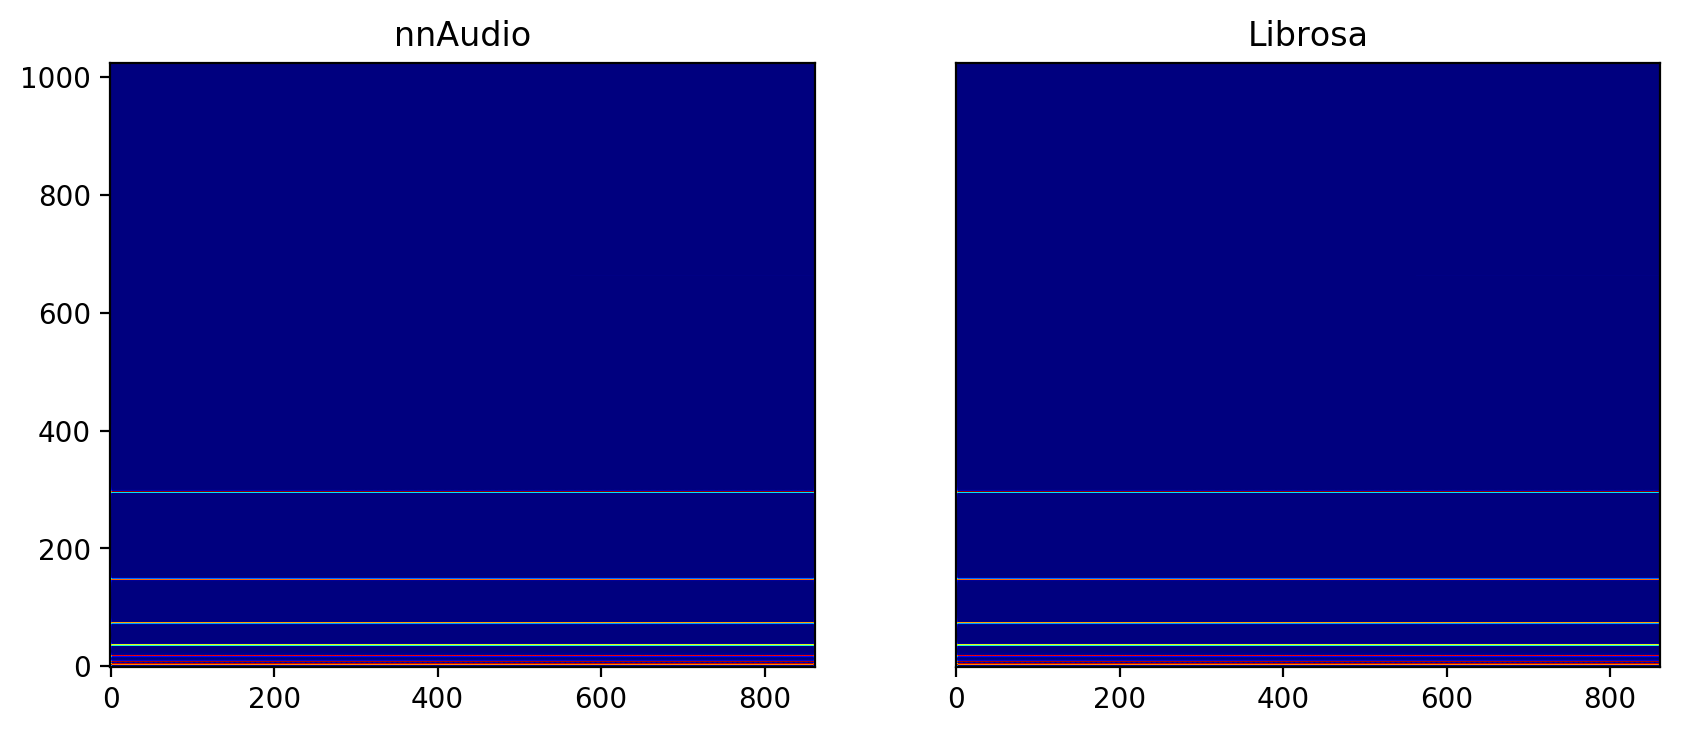

In [12]:
fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(stft_x[0], aspect='auto', origin='lower', cmap=cmap)
ax[1].imshow(abs(output_lib), aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")

In [13]:
print("Linear sweep all close ", np.allclose(stft_x[0].numpy(), output_lib, rtol=1e-2, atol=1e-2))

Linear sweep all close  True


# STFT log-freq

sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range


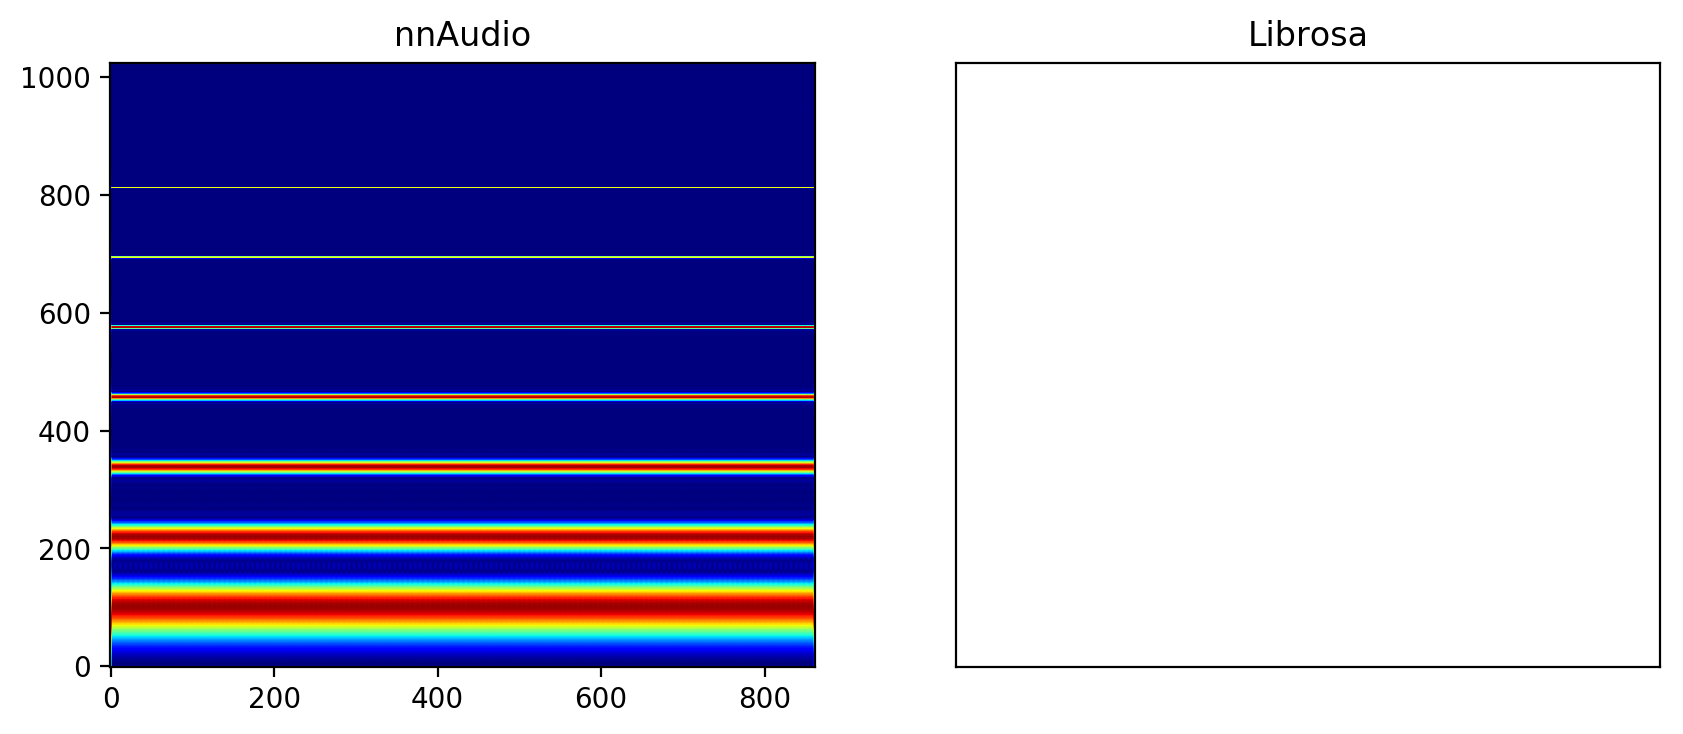

In [14]:
stft_layer = Spectrogram.STFT(freq_scale='log', fmin=fmin, fmax=22050, sr=44100)
stft_log_x = stft_layer(torch.tensor(x[None, None, :]))

fig , ax = plt.subplots(1,2, dpi=200, figsize=(10,4))
ax[0].imshow(stft_log_x[0], aspect='auto', origin='lower', cmap=cmap)
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[0].title.set_text("nnAudio")
ax[1].title.set_text("Librosa")